<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2
from Functions.binary_dm import transform_binary_to_depthmap
from scipy.stats import uniform, randint
import torch
import torchvision
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Tiefenkarte lesen und plotten

Einlesen der Binary

In [3]:
binary_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\Kohlrabi\DepthMap.bin"
depth_map = transform_binary_to_depthmap(binary_url)

In [4]:
print(depth_map.dtype)


float16


Einlesen des RGB image

In [5]:
rgb_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\Kohlrabi\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [6]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

Plotten der Tiefenkarte

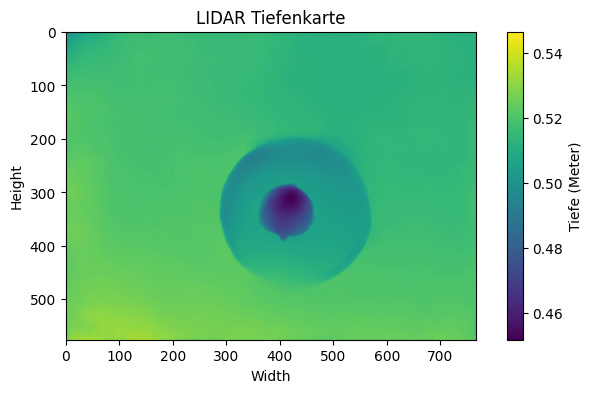

In [7]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap = "viridis")
plt.colorbar(label="Tiefe (Meter)")
plt.title("LIDAR Tiefenkarte")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [8]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

# Intrinsic camera calibration

In [9]:
dm_height, dm_width= depth_map.shape
print(f"height:{dm_height} , width:{dm_width}")

height:576 , width:768


Skalierung des RGB-Bilds, um die Segmentierung korrekt auf die Tiefenkarte anzuwenden

In [10]:
# Bild auf 576x768 skalieren
rgb_im = rgb_im.resize((768, 576), Image.BILINEAR)  # BILINEAR für weiche Skalierung

In [11]:
rgb_im.size

(768, 576)

## Segmentierung

In [12]:
# Mask R-CNN Modell mit COCO-Gewichten laden
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Bild laden
image = rgb_im
image_tensor = F.to_tensor(image).unsqueeze(0)

# Bild durch das Modell laufen lassen
with torch.no_grad():
    prediction = model(image_tensor)

C:\Users\Diren\Masterarbeit\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Diren\Masterarbeit\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
for i, label in enumerate(prediction[0]['labels']):
    score = prediction[0]['scores'][i].item()
    print(f"Objekt {i}: COCO-Klasse {label}, Score: {score:.2f}")


Objekt 0: COCO-Klasse 51, Score: 0.91
Objekt 1: COCO-Klasse 67, Score: 0.66
Objekt 2: COCO-Klasse 47, Score: 0.17
Objekt 3: COCO-Klasse 52, Score: 0.05


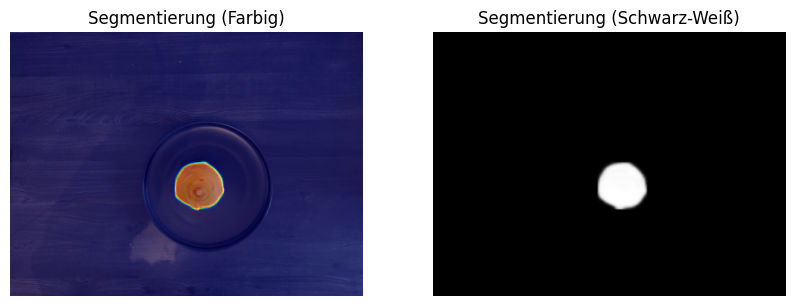

In [49]:

# **Erste Plot: Originalbild mit Overlay (Farbig)**
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # Erste Hälfte des Plots
plt.imshow(image)

for i, mask in enumerate(prediction[0]['masks']):
    if prediction[0]['labels'][i] == 52: # 51 scheinbar bowl #47 scheinabr teller
        mask_np = mask.squeeze().cpu().numpy()
        plt.imshow(mask_np, alpha=0.5, cmap="jet")  # Farbliche Überlagerung

plt.axis("off")
plt.title("Segmentierung (Farbig)")

# **Zweiter Plot: Nur die Maske in Schwarz-Weiß**
plt.subplot(1, 2, 2)  # Zweite Hälfte des Plots
plt.imshow(mask_np, cmap="gray")
plt.axis("off")
plt.title("Segmentierung (Schwarz-Weiß)")

plt.show()


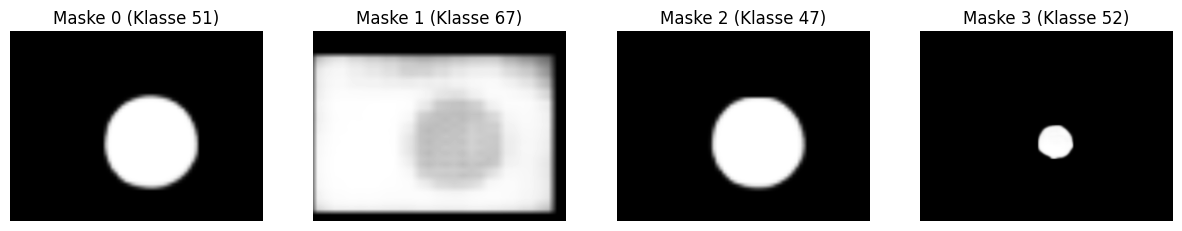

In [47]:
# fig, axes = plt.subplots(1, len(prediction[0]['masks']), figsize=(15, 5))
# 
# for i, mask in enumerate(prediction[0]['masks']):
#     mask_np = mask.squeeze().cpu().numpy()
#     axes[i].imshow(mask_np, cmap="gray")
#     axes[i].set_title(f"Maske {i} (Klasse {prediction[0]['labels'][i].item()})")
#     axes[i].axis("off")
# 
# plt.show()


maske auf depth anwenden

In [16]:
import numpy as np
import torch

def split_depth_map(depth_map, mask):
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy()  # In NumPy-Array umwandeln, falls Tensor

    depth_foreground = depth_map * mask  # Tiefenwerte innerhalb der Maske
    depth_background = depth_map * (1 - mask)  # Tiefenwerte außerhalb der Maske

    return depth_foreground, depth_background


# Tiefenkarten berechnen
depth_foreground, depth_background = split_depth_map(depth_map, mask_np)

# Optional: Werte ausgeben
print("Durchschnittliche Tiefe (Objekt):", np.mean(depth_foreground[depth_foreground > 0]))
print("Durchschnittliche Tiefe (Hintergrund):", np.mean(depth_background[depth_background > 0]))


Durchschnittliche Tiefe (Objekt): 0.3540383
Durchschnittliche Tiefe (Hintergrund): 0.44592845


Filterung von Ausreißern am Rand der Segmentierung

In [17]:
mask_np = (mask_np > 0.5).astype(np.uint8)  # Setzt alles über 0.5 auf 1, den Rest auf 0
depth_foreground = depth_map * mask_np

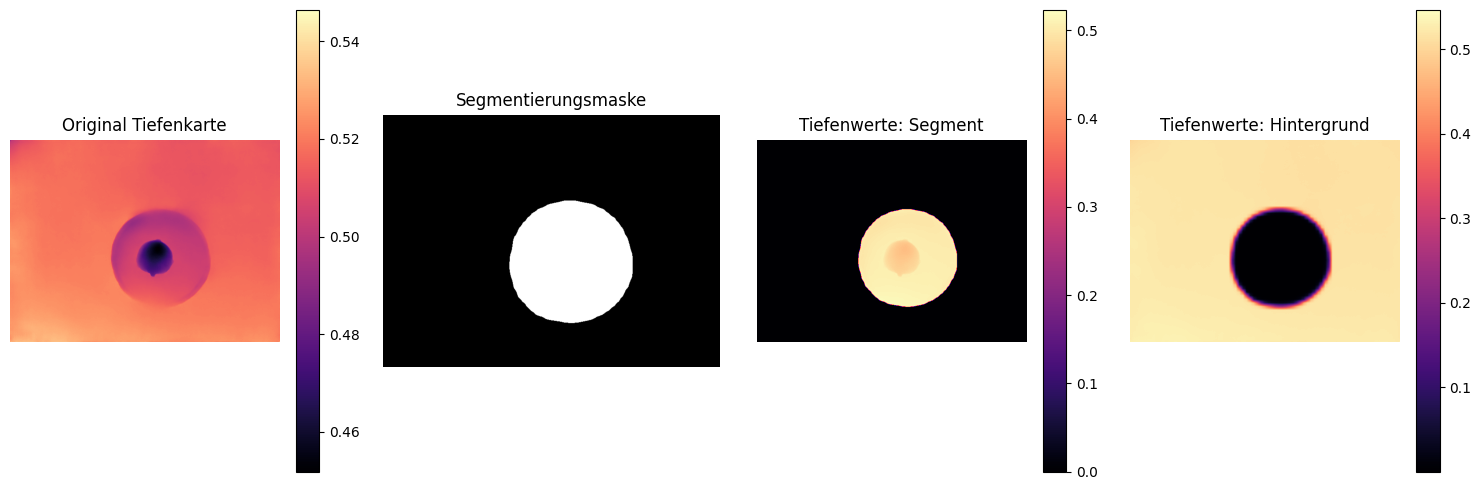

In [22]:
import matplotlib.pyplot as plt

def visualize_depth_maps(depth_map, depth_foreground, depth_background, mask):
    plt.figure(figsize=(15, 5))
    
    # Binäre Maske
    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.title("Segmentierungsmaske")
    
    # Original Tiefenkarte
    plt.subplot(1, 4, 1)
    plt.imshow(depth_map, cmap="magma")
    plt.colorbar()
    plt.axis("off")
    plt.title("Original Tiefenkarte")
    
    # Tiefenkarte für das Objekt (Foreground)
    plt.subplot(1, 4, 3)
    plt.imshow(depth_foreground, cmap="magma")
    plt.colorbar()
    plt.axis("off")
    plt.title("Tiefenwerte: Segment")
    
    # Tiefenkarte für den Hintergrund (Background)
    plt.subplot(1, 4, 4)
    plt.imshow(depth_background, cmap="magma")
    plt.colorbar()
    plt.axis("off")
    plt.title("Tiefenwerte: Hintergrund")
    
    plt.tight_layout()
    plt.show()

# Visualisierung aufrufen
visualize_depth_maps(depth_map, depth_foreground, depth_background, mask_np)


intrinsische Matrix

In [24]:
intrinsic_matrix = np.array([
    [2943.626708984375, 0, 2006.96923828125],
    [0, 2943.626708984375, 1519.7119140625],
    [0, 0, 1]
])

print(intrinsic_matrix)


[[2.94362671e+03 0.00000000e+00 2.00696924e+03]
 [0.00000000e+00 2.94362671e+03 1.51971191e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [25]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [26]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [27]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[560.69080171   0.         382.27985491]
 [  0.         560.69080171 289.46893601]
 [  0.           0.           1.        ]]


scaled intrinsic

In [28]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 560.6908017113095, fy: 560.6908017113095, cx: 382.2798549107143, cy: 289.46893601190476


# Create point cloud

Open3D Object without metric scaling

In [29]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [30]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [31]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=3.0,  # Maximal erlaubte Tiefe. 3 Meter reichen für unsere Ansprüche.
    stride=1  # Jeder Pixel wird genutztbei Stride = 1
)


In [32]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368


In [33]:
o3d.visualization.draw_geometries([pcd])


In [34]:
pcd_array = np.asarray(pcd.points, dtype=np.float16)

## depth foreground

In [35]:
depth_foreground

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)

In [36]:
# 📌 2️⃣ Open3D Image erstellen (Nullwerte bleiben, werden aber gefiltert)
depth_image = o3d.geometry.Image(depth_foreground.astype(np.float32))

# 📌 4️⃣ Punktwolke aus der Tiefenkarte erstellen (nur segmentierte Punkte)
pcd_foreground = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # Falls Tiefendaten in Metern vorliegen
    depth_trunc=3.0,  # Maximal erlaubte Tiefe (ggf. anpassen)
    stride=1
)

In [37]:
pcd_foreground_array = np.asarray(pcd_foreground.points, dtype=np.float16)

In [38]:
pcd_foreground_array

array([[ 0.027  , -0.084  ,  0.5093 ],
       [ 0.02788, -0.0839 ,  0.509  ],
       [ 0.02878, -0.0839 ,  0.509  ],
       ...,
       [ 0.0478 ,  0.1714 ,  0.518  ],
       [ 0.0487 ,  0.1714 ,  0.518  ],
       [ 0.04962,  0.1714 ,  0.518  ]], dtype=float16)

In [39]:
# 📌 6️⃣ Visualisierung (Nur segmentierte Punkte)
o3d.visualization.draw_geometries([pcd_foreground])

In [32]:

# 📌 2️⃣ Filtere nur Punkte, bei denen die Z-Koordinate größer als 0.01 ist
mask_valid = pcd_foreground_array[:, 2] > 0.01
points_filtered = pcd_foreground_array[mask_valid]  # Behalte nur die gültigen Punkte

# 📌 3️⃣ Neue Punktwolke mit gefilterten Punkten erstellen
pcd_filtered = o3d.geometry.PointCloud()
pcd_filtered.points = o3d.utility.Vector3dVector(points_filtered)

# 📌 4️⃣ Visualisiere die bereinigte Punktwolke
o3d.visualization.draw_geometries([pcd_filtered])

# Clean Point Cloud

## Estimating normals

In [305]:
nn_distance = np.mean(pcd.compute_nearest_neighbor_distance())

print(nn_distance)

0.0009107557441340922


In [306]:
radius_normals = nn_distance * 4

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd])

PointCloud with 442368 points.

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [307]:
pcd_center = pcd.get_center()
pcd.translate(pcd_center)

PointCloud with 442368 points.

## Plane segmentation with RANSAC

Randomized Search

In [40]:
# Hyperparameter-Ranges für Randomized Search
random_params = {
    "distance_threshold": uniform(0.001, 0.02),  # Werte zwischen 0.001 und 0.02
    "ransac_n": randint(3, 15),  # Werte zwischen 3 und 15
    "num_iterations": randint(1000, 10000)  # Werte zwischen 1000 und 10000
}

# Funktion zur Evaluierung der Ebenensegmentierung
def evaluate_ransac(distance_threshold, ransac_n, num_iterations):
    plane_model, inliers = pcd_foreground.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )
    return len(inliers)  # Ziel: Maximale Anzahl an Inliers

# Randomized Search
n_trials = 30  # Anzahl der getesteten Konfigurationen
best_score = 0
best_params = None

for _ in range(n_trials):
    params = {key: dist.rvs() for key, dist in random_params.items()}
    score = evaluate_ransac(**params)
    
    if score > best_score:
        best_score = score
        best_params = params

print("Beste Parameter:", best_params)

Beste Parameter: {'distance_threshold': 0.02046120924006077, 'ransac_n': 10, 'num_iterations': 9162}


RANSAC

In [45]:
plane_model, inliers = pcd_foreground.segment_plane(
    distance_threshold=0.02046120924006077
, # für bilder mit teller sind 0,005 besser geeignet! wie weit darf ein punkt entfernt sein, um als inlier zu gelten.
    ransac_n=10,
    num_iterations=9162,
    probability=0.9999
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
pcd_plane = pcd_foreground.select_by_index(inliers)
inlier_cloud = pcd_foreground.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd_foreground.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
#o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [46]:
o3d.visualization.draw_geometries([outlier_cloud,pcd_plane])

In [231]:
pcd_object = outlier_cloud

In [232]:
o3d.visualization.draw_geometries([pcd_plane], window_name="RANSAC Plane") 

In [233]:
o3d.visualization.draw_geometries([pcd_object], window_name="Object") 

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

Beste Parameter für Plane

In [234]:
# Parameter-Suchbereich definieren
random_params_sor = {
    "nb_neighbors": randint(50, 200),  # Werte zwischen 50 und 200
    "std_ratio": uniform(0.8, 2.0)    # Werte zwischen 0.8 und 2.8
}

# Evaluierungsfunktion für SOR
def evaluate_sor(nb_neighbors, std_ratio, pointcloud):
    pcd_copy = pointcloud  # Kopie der Punktwolke, um Originaldaten zu erhalten
    cl, ind = pcd_copy.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    return len(ind)  # Maximierung der Anzahl der verbleibenden Punkte


# Randomized Search
n_trials = 30  # Anzahl der getesteten Parameterkombinationen
best_score_plane = 0
best_params_plane = None

for _ in range(n_trials):
    params = {key: dist.rvs() for key, dist in random_params_sor.items()}
    score = evaluate_sor(**params, pointcloud=pcd_plane)  # SOR für Plane

    if score > best_score_plane:
        best_score_plane = score
        best_params_plane = params

print("Beste Parameter SOR Plane:", best_params_plane)

Beste Parameter SOR Plane: {'nb_neighbors': 83, 'std_ratio': 2.726904853893413}


Beste Parameter für Object

In [235]:
best_score_object = 0
best_params_object = None

for _ in range(n_trials):
    params = {key: dist.rvs() for key, dist in random_params_sor.items()}
    score = evaluate_sor(**params, pointcloud=pcd_object)  # SOR für Object

    if score > best_score_object:
        best_score_object = score
        best_params_object = params

print("Beste Parameter SOR Object:", best_params_object)

Beste Parameter SOR Object: {'nb_neighbors': 146, 'std_ratio': 1.6226490637985544}


Function to visualize clean pointcloud and the removed outliers

In [236]:
# Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html
# Verbesserte Laufzeit der vorherigen Funktion

def display_outliers_fast(cloud, ind):
    """ Visualisiert die entfernten Punkte (Outlier) und die verbleibenden Punkte (Inlier) schneller mit NumPy. """
    
    if len(ind) == 0:
        print("Keine Outlier gefunden!")
        return

    points = np.asarray(cloud.points)  # Punktwolke als NumPy-Array
    outlier_mask = np.ones(len(points), dtype=bool)  # Alle Punkte als Outlier markieren
    outlier_mask[ind] = False  # Inlier entfernen → übrig bleiben nur Outlier

    # Neue Punktwolke für Outlier erstellen
    outlier_cloud = o3d.geometry.PointCloud()
    outlier_cloud.points = o3d.utility.Vector3dVector(points[outlier_mask])
    outlier_cloud.paint_uniform_color([1, 0, 0])  # Rot für Outlier

    # Neue Punktwolke für Inlier erstellen
    inlier_cloud = o3d.geometry.PointCloud()
    inlier_cloud.points = o3d.utility.Vector3dVector(points[ind])
    inlier_cloud.paint_uniform_color([0, 1, 0])  # Grün für Inlier

    print(f"Anzahl der Inlier: {len(ind)}")
    print(f"Anzahl der Outlier: {np.sum(outlier_mask)}")

    # Schnellere Visualisierung mit Inlier und Outlier
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

### Clean Plane

Removing the outliers from the plane

In [237]:
cl, ind = pcd_plane.remove_statistical_outlier(nb_neighbors=72, std_ratio=2.566566230244333)

Displaying inliers and outliers

In [238]:
display_outliers_fast(pcd_plane, ind)

Anzahl der Inlier: 431320
Anzahl der Outlier: 9632


We will use this PC from now on as Plane

In [239]:
pcd_plane = cl
o3d.visualization.draw_geometries([pcd_plane])

In [240]:
plane_array = np.asarray(pcd_plane.points, dtype=np.float16)

### Clean Object 

In [241]:
cl, ind = pcd_object.remove_statistical_outlier(nb_neighbors=134, std_ratio=1.0722416681876064) #gute Ergebnisse mit diesen Werten bisher

Visualizing the new PC of the object

In [242]:
display_outliers_fast(pcd_object, ind)

Anzahl der Inlier: 1414
Anzahl der Outlier: 2


In [243]:
pcd_object = cl
o3d.visualization.draw_geometries([pcd_object])

In [244]:
pcd_object_array = np.asarray(pcd_object.points, dtype=np.float16)

In [245]:
print(pcd_object_array.dtype)

float16


# Punktwolke ausfüllen

Das Problem beim Extrahieren des jeweiligen Lebensmittels ist, dass, da nicht alle Punkte in der Tiefenkarte sichtbar sind, diese Punkte fehlen und das Objekt an Höhe verliert, sobald man den RANSAC-Algorithmus ausführt.
Um die korrekte Höhe beizubehalten, kann man das Lebensmittel bis zur ebenen Fläche erweitern und somit vervollständigen.  

Wir benötigen die untersten Punkte der Objekt-Punktwolke

In [259]:
# Maximalen z-Wert des Objekts bestimmen
max_z_object = max(pcd_object_array[:, 2].tolist()) 
print(f"Tiefster z-Wert des Objekts: {max_z_object}")

Tiefster z-Wert des Objekts: 1.0146484375


In [260]:
# Durchschnitt
avg_z_plane = plane_array[:, 2].mean()
print(f"Durchschnittliche Tiefe der Ebene: {avg_z_plane}")

Durchschnittliche Tiefe der Ebene: 1.0341796875


In [261]:
# Minimalen z-Wert der Ebene bestimmen
max_z_plane = plate_array[:, 2].max()
print(f"Tiefster z-Wert der Ebene: {max_z_plane}")

Tiefster z-Wert der Ebene: 1.0546875


This code extends all the points of the object and thus creates a dense object. 

In [262]:
o3d.visualization.draw_geometries([pcd_object,pcd_plane])


In [263]:
# 4. Punkte in Z-Richtung erweitern

new_points_dos = []
for x, y, z in pcd_object_array:
    # Falls der Punkt zu tief liegt, berechne eine Korrektur
    
    current_z = z
    while current_z < avg_z_plate:
        current_z += 0.0015
        if current_z > avg_z_plate:
            break
        new_points_dos.append([x, y, current_z])


# 5. Neue Punkte zur Open3D Punktwolke hinzufügen
new_points_dos = np.array(new_points_dos)  # Am Ende in ein numpy-Array umwandeln

# 7. Punktwolke der neuen Punkte visualisieren

new_points_pcd_dos = o3d.geometry.PointCloud()
new_points_pcd_dos.points = o3d.utility.Vector3dVector(new_points_dos)

o3d.visualization.draw_geometries([new_points_pcd_dos])

In [264]:
o3d.visualization.draw_geometries([new_points_pcd_dos, pcd_plane])

Punkte generieren Quelle: https://stackoverflow.com/questions/65774814/adding-new-points-to-point-cloud-in-real-time-open3d

# Objekte clustern

## DBSCAN

In [137]:
# DBSCAN-Clustering
eps = 0.05  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(plate_pdc.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
plate_pdc.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([plate_pdc])

Anzahl der Cluster: 2


## Zusammenfassung der Punktwolke

## Ausdehnung des Objekts

In [52]:
bounds = new_points_pcd_dos.get_max_bound() - new_points_pcd_dos.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.3f}, y={bounds[1]:.3f}, z={bounds[2]:.3f}")

Ausdehnung der Punktwolke: x=0.155, y=0.047, z=0.024


# Volumenberechnung

## Voxelization

Sehr wichtig!: Wenn wir statt einfach nur die border zu erweitern und mit der ursprünglichen PCD des Objekts verbinden, die ursprüngliche PCD (ist ja eine Hülle) erweitern und so ein ausgefülltes Objekt erhalten und dieses dann nutzen, um mit Voxelization das Volumen zu erhalten, dann ist das Ergebnis viel besser. Das 

In [87]:
# Voxelgröße (anpassen je nach Detailgrad)
voxel_size = 0.0015  # 1,3mm pro Voxel ist gut. ggf. kann ich ein algorithmus schrieben der die "perfekte" size findet in dem dieser selbst den wert nach oben oder unten justiert

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(new_points_pcd_dos, voxel_size=voxel_size)

# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)

print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.6f} m³")

# **Visualisierung der Voxel**
o3d.visualization.draw_geometries([voxel_grid])

Geschätztes Volumen der Punktwolke: 0.000124 m³


## Convex Hull

In [57]:
# calculate hull
hull_mesh, hull_vertices = new_points_pcd_dos.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([new_points_pcd_dos, hull_ls])

volume = hull_mesh.get_volume()


In [58]:
volume_ml = volume * 1_000_000  # Umrechnung von m³ in ml
print(f"Volumen: {volume_ml:.2f} ml")

Volumen: 92.64 ml


## Bounding Box

In [43]:
import open3d as o3d
import numpy as np


# Axis-Aligned Bounding Box (AABB) berechnen und visualisieren
# aabb = new_points_pcd_dos.get_axis_aligned_bounding_box()
# aabb.color = (1, 0, 0)  # Rot

# Oriented Bounding Box (OBB) berechnen
oriented_bb = new_points_pcd_dos.get_oriented_bounding_box()
oriented_bb.color = (0, 1, 0)  # Grün

# Bounding-Boxen und Punktwolke visualisieren
o3d.visualization.draw_geometries([new_points_pcd_dos, oriented_bb])

# Volumenberechnung der OBB
obb_extents = oriented_bb.extent
obb_volume = obb_extents[0] * obb_extents[1] * obb_extents[2]

print(f"Volumen der Oriented Bounding Box (OBB): {obb_volume:.2f}")

# #Debugging: Bounding-Box-Größe prüfen
# min_bound = new_points_pcd_dos.get_min_bound()
# max_bound = new_points_pcd_dos.get_max_bound()
# print(f"Min Bound: {min_bound}, Max Bound: {max_bound}")
# print(f"AABB Größe: {aabb.get_extent()}")
# print(f"OBB Größe: {obb_extents}")

obb_volume = np.prod(obb_extents)
print(f"Korrigiertes OBB-Volumen: {obb_volume:.6f} m³")


Volumen der Oriented Bounding Box (OBB): 0.01
Korrigiertes OBB-Volumen: 0.011485 m³


## Alpha shapes

In [59]:
nn_distance = np.mean(new_points_pcd_dos.compute_nearest_neighbor_distance())

print(nn_distance)
radius_normals = nn_distance * 4

new_points_pcd_dos.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16),
                     fast_normal_computation=True)

new_points_pcd_dos.paint_uniform_color([0.6, 0.6, 0.6])
o3d.visualization.draw_geometries([new_points_pcd_dos])

0.0008885780013882576


In [60]:
# Quelle Code: https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html
# Quelle Theorie:  [Edelsbrunner1983] Edelsbrunner and D. G. Kirkpatrick and R. Seidel: On the shape of a set of points in the plane, IEEE Transactions on Information Theory, 29 (4): 551–559, 1983

alpha = 0.6
print(f"alpha={alpha:.3f}")
alpha_shape  = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(new_points_pcd_dos, alpha)
alpha_shape.compute_vertex_normals()
o3d.visualization.draw_geometries([alpha_shape], mesh_show_back_face=True)



alpha=0.600
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra 

In [95]:
# Volumenberechnung mit Tetrahedron Decomposition (Delaunay Triangulation)
def compute_mesh_volume(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    volume = 0.0
    for tri in triangles:
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0  # Volumen eines Tetraeders
        volume += tetra_volume
    
    return abs(volume)

# Volumen berechnen
volumen = compute_mesh_volume(alpha_shape)
print(f"Volumen des Alpha Shapes: {volumen:.5f} m³")


Volumen des Alpha Shapes: 0.00079 m³


## Delauney

In [97]:
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(new_points_pcd_dos, depth=9)

In [98]:
o3d.visualization.draw_geometries([mesh], window_name="Poisson Mesh")

#  Test

## interpolate pcd for better results using voxelization

In [45]:
cl, ind = new_points_pcd_dos.remove_statistical_outlier(nb_neighbors=400, std_ratio=1.0) #gute Ergebnisse mit diesen Werten bisher

In [46]:
new_points_pcd_dos

PointCloud with 158006 points.

In [47]:
cl

PointCloud with 136558 points.

In [48]:
o3d.visualization.draw_geometries([cl])


In [49]:
nn_distance = np.mean(cl.compute_nearest_neighbor_distance())

print(nn_distance)

0.0008461078819643869


In [50]:
radius_normals = nn_distance * 4

cl.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

cl.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd])

PointCloud with 136558 points.

In [51]:
# Poisson-Rekonstruktion
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(cl, depth=9)

# Punktwolke aus Mesh extrahieren
pcd_dense = mesh.sample_points_uniformly(number_of_points=1000000)  # Anzahl erhöhen für mehr Dichte

In [ ]:
o3d.visualization.draw_geometries([pcd_dense])

In [52]:
cl, ind = pcd_dense.remove_statistical_outlier(nb_neighbors=400,
                                                        std_ratio=1.0)  #gute Ergebnisse mit diesen Werten bisher

In [53]:
o3d.visualization.draw_geometries([cl])

In [54]:
# Voxelgröße (anpassen je nach Detailgrad)
voxel_size = 0.007  # 1,3mm pro Voxel ist gut. ggf. kann ich ein algorithmus schrieben der die "perfekte" size findet in dem dieser selbst den wert nach oben oder unten justiert

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(cl, voxel_size=voxel_size)

# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)

print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.6f} m³")

# **Visualisierung der Voxel**
o3d.visualization.draw_geometries([voxel_grid])

Geschätztes Volumen der Punktwolke: 0.000201 m³


In [55]:
 pcd_dense

PointCloud with 1000000 points.

## DBSCAN-Clustering

In [139]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd])

Anzahl der Cluster: 1


In [ ]:
for cluster_id in np.unique(labels):
    cluster_size = np.sum(labels == cluster_id)
    if cluster_id == -1:
        print(f"Rauschen: {cluster_size} Punkte")
    else:
        print(f"Cluster {cluster_id}: {cluster_size} Punkte")

In [ ]:
# ID des zu entfernenden Clusters
cluster_to_remove = 1  

# Indizes der Punkte im Cluster finden
indices_to_remove = np.where(labels == cluster_to_remove)[0]

# Punktwolke ohne unerwünschte Cluster erstellen
remaining_cloud = pcd.select_by_index(indices_to_remove, invert=True)

# Visualisierung
o3d.visualization.draw_geometries([remaining_cloud], window_name="Bereinigte Punktwolke")
